In [31]:
import torch
import torchvision
import torch.optim as optim
import argparse
import matplotlib
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import model
from tqdm import tqdm
from torchvision import datasets
from scipy.stats import norm
from torch.utils.data import DataLoader
from torchvision.utils import save_image

from matplotlib import pyplot as plt
matplotlib.style.use('ggplot')

In [32]:
losses_train = []
losses_val = []
# i_score_train = []
# i_score_val=[]

In [33]:
#Learning parameters
epochs = 10
batch_size = 256
lr = 0.0002
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [34]:
# transforms
transform = transforms.Compose([
    transforms.ToTensor(),
])

train_data = datasets.MNIST(
    root='../input/data',
    train=True,
    download=True,
    transform=transform
)
torch.Size([14000,28,28])
val_data = datasets.MNIST(
    root='../input/data',
    train=False,
    download=True,
    transform=transform
)
torch.Size([6000,28,28])
# training and validation data loaders
train_loader = DataLoader(
    train_data,
    batch_size=batch_size,
    shuffle=True
)
val_loader = DataLoader(
    val_data,
    batch_size=batch_size,
    shuffle=False
)

In [35]:
model = model.LinearVAE().to(device)
print(model)
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.BCELoss(reduction='sum')

LinearVAE(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc31): Linear(in_features=256, out_features=2, bias=True)
  (fc32): Linear(in_features=256, out_features=2, bias=True)
  (fc4): Linear(in_features=2, out_features=256, bias=True)
  (fc5): Linear(in_features=256, out_features=512, bias=True)
  (fc6): Linear(in_features=512, out_features=784, bias=True)
)


In [36]:
def final_loss(bce_loss, mu, logvar):
    """
    This function will add the reconstruction loss (BCELoss) and the 
    KL-Divergence.
    KL-Divergence = 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    :param bce_loss: recontruction loss
    :param mu: the mean from the latent vector
    :param logvar: log variance from the latent vector
    """
    BCE = bce_loss 
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

In [37]:
def fit(model, dataloader):
    model.train()
    running_loss = 0.0
    for i, data in tqdm(enumerate(dataloader), total=int(len(train_data)/dataloader.batch_size)):
        data, _ = data
        data = data.to(device)
        data = data.view(data.size(0), -1)
        optimizer.zero_grad()
        reconstruction, mu, logvar = model(data)
        bce_loss = criterion(reconstruction, data)
        loss = final_loss(bce_loss, mu, logvar)
        running_loss += loss.item()
        loss.backward()
        optimizer.step()
    train_loss = running_loss/len(dataloader.dataset)
    losses_train.append(train_loss)
    return train_loss

In [38]:
def validate(model, dataloader):
    model.eval()
    running_loss = 0.0
#     inception_score = 0.0
    with torch.no_grad():
        for i, data in tqdm(enumerate(dataloader), total=int(len(val_data)/dataloader.batch_size)):
            data, _ = data
            data = data.to(device)
            data = data.view(data.size(0), -1)
            reconstruction, mu, logvar = model(data)
            bce_loss = criterion(reconstruction, data)
            loss = final_loss(bce_loss, mu, logvar)
            running_loss += loss.item()
        
            # save the last batch input and output of every epoch
            if i == int(len(val_data)/dataloader.batch_size) - 1:
                num_rows = 8
                both = torch.cat((data.view(batch_size, 1, 28, 28)[:8], 
                                  reconstruction.view(batch_size, 1, 28, 28)[:8]))
                save_image(both.cpu(), f"../outputs/output{epoch}.png", nrow=num_rows)
    val_loss = running_loss/len(dataloader.dataset)
    losses_val.append(val_loss)
    return val_loss

In [39]:
train_loss = []
val_loss = []
for epoch in range(epochs):
    print(f"Epoch {epoch+1} of {epochs}")
    train_epoch_loss = fit(model, train_loader)
    val_epoch_loss = validate(model, val_loader)
    train_loss.append(train_epoch_loss)
    val_loss.append(val_epoch_loss)
    print(f"Train Loss: {train_epoch_loss:.4f}")
    print(f"Val Loss: {val_epoch_loss:.4f}")

  0%|                                                                                          | 0/234 [00:00<?, ?it/s]C:\Users\HP\anaconda3\lib\site-packages\torch\nn\functional.py:1625: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
  1%|▋                                                                                 | 2/234 [00:00<00:12, 17.87it/s]

Epoch 1 of 10


235it [00:05, 43.23it/s]                                                                                               
40it [00:00, 42.81it/s]                                                                                                
  2%|█▍                                                                                | 4/234 [00:00<00:06, 36.07it/s]

Train Loss: 237.1600
Val Loss: 191.2074
Epoch 2 of 10


235it [00:05, 44.82it/s]                                                                                               
40it [00:00, 47.93it/s]                                                                                                
  2%|█▍                                                                                | 4/234 [00:00<00:06, 34.70it/s]

Train Loss: 182.9213
Val Loss: 175.5061
Epoch 3 of 10


235it [00:05, 44.71it/s]                                                                                               
40it [00:00, 50.27it/s]                                                                                                
  2%|█▍                                                                                | 4/234 [00:00<00:06, 33.65it/s]

Train Loss: 173.0006
Val Loss: 170.0313
Epoch 4 of 10


235it [00:05, 44.64it/s]                                                                                               
40it [00:00, 50.95it/s]                                                                                                
  2%|█▍                                                                                | 4/234 [00:00<00:06, 33.67it/s]

Train Loss: 168.5606
Val Loss: 167.3840
Epoch 5 of 10


235it [00:05, 44.21it/s]                                                                                               
40it [00:00, 51.66it/s]                                                                                                
  2%|█▍                                                                                | 4/234 [00:00<00:06, 38.14it/s]

Train Loss: 166.1537
Val Loss: 165.4684
Epoch 6 of 10


235it [00:05, 44.50it/s]                                                                                               
40it [00:00, 51.55it/s]                                                                                                
  1%|█                                                                                 | 3/234 [00:00<00:07, 29.89it/s]

Train Loss: 164.2218
Val Loss: 163.6434
Epoch 7 of 10


235it [00:05, 43.82it/s]                                                                                               
40it [00:00, 51.56it/s]                                                                                                
  2%|█▍                                                                                | 4/234 [00:00<00:06, 33.64it/s]

Train Loss: 162.4272
Val Loss: 161.9677
Epoch 8 of 10


235it [00:05, 44.49it/s]                                                                                               
40it [00:00, 51.27it/s]                                                                                                
  2%|█▍                                                                                | 4/234 [00:00<00:06, 33.67it/s]

Train Loss: 160.6938
Val Loss: 160.3713
Epoch 9 of 10


235it [00:05, 43.51it/s]                                                                                               
40it [00:00, 51.16it/s]                                                                                                
  2%|█▍                                                                                | 4/234 [00:00<00:06, 33.64it/s]

Train Loss: 159.1071
Val Loss: 158.8151
Epoch 10 of 10


235it [00:05, 44.04it/s]                                                                                               
40it [00:00, 51.26it/s]                                                                                                

Train Loss: 157.7062
Val Loss: 157.4044


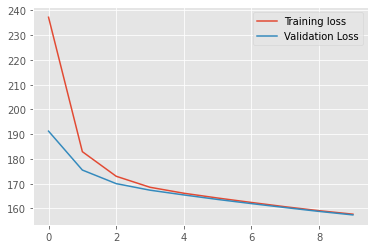

In [40]:
plt.figure()
plt.plot(losses_train, label='Training loss')
plt.plot(losses_val, label='Validation Loss')
plt.legend()
plt.savefig('VAE_outputs/VAEloss.png')